In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

sys.path.append(os.path.abspath("../src"))
from parse_apple_health import parse_health_metrics
from ai_sleep import engineer_features

sns.set(style="whitegrid")

In [8]:
daily_sleep = pd.read_csv("results/daily_sleep_summary.csv")
sleep_df = pd.read_csv("results/sleep_df.csv")

health_df = parse_health_metrics("../data/export.xml")

print("✅ Data Loaded:")
print(f"Sleep entries: {len(sleep_df)}")
print(f"Daily summary: {len(daily_sleep)}")
print(f"Health metrics: {len(health_df)}")


✅ Data Loaded:
Sleep entries: 1583
Daily summary: 78
Health metrics: 143301


In [9]:
feature_df = engineer_features(daily_sleep, sleep_df, health_df)
print("✅ Features engineered. Columns available:")
print(feature_df.columns.tolist()[:15], "...")


✅ Features engineered. Columns available:
['date', 'HKCategoryValueSleepAnalysisAsleepCore', 'HKCategoryValueSleepAnalysisAsleepDeep', 'HKCategoryValueSleepAnalysisAsleepREM', 'HKCategoryValueSleepAnalysisAsleepUnspecified', 'HKCategoryValueSleepAnalysisAwake', 'total_sleep_hours', 'bedtime_hour', 'wake_hour', 'prev_sleep', 'sleep_debt', 'rolling_7d_avg', 'weekday_num', 'activity', 'heart_rate'] ...


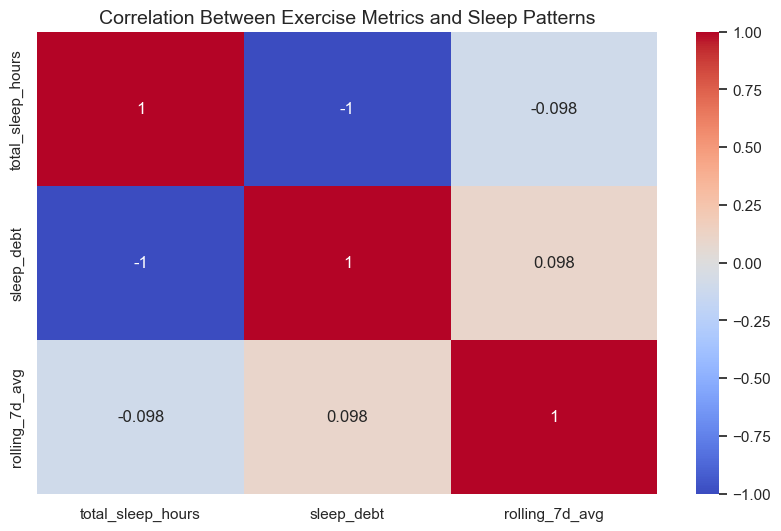

In [10]:
exercise_cols = [
    c for c in feature_df.columns 
    if any(x in c.lower() for x in ['step', 'active', 'energy', 'workout'])
]

sleep_cols = ['total_sleep_hours', 'sleep_debt', 'rolling_7d_avg']

corr_df = feature_df[exercise_cols + sleep_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Exercise Metrics and Sleep Patterns", fontsize=14)
plt.show()


In [11]:
high_corr = corr_df['total_sleep_hours'].drop('total_sleep_hours').sort_values(ascending=False)
print("🏃‍♂️ Top Exercise Factors Correlated with Total Sleep Hours:\n")
print(high_corr.head(5))


🏃‍♂️ Top Exercise Factors Correlated with Total Sleep Hours:

rolling_7d_avg   -0.098129
sleep_debt       -1.000000
Name: total_sleep_hours, dtype: float64


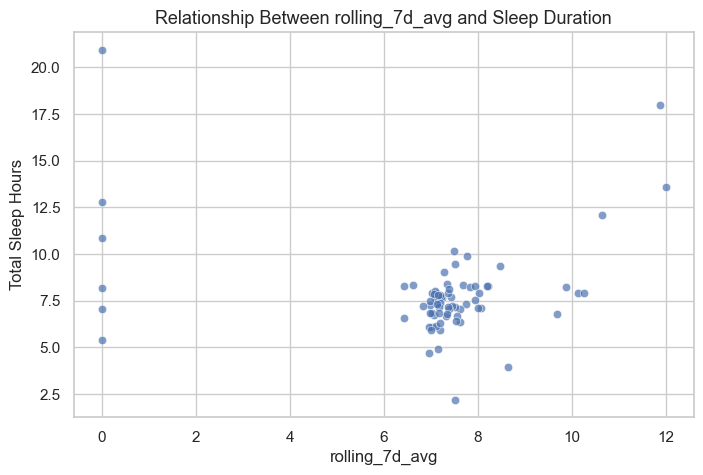

In [12]:
top_exercise = high_corr.index[0]

plt.figure(figsize=(8,5))
sns.scatterplot(data=feature_df, x=top_exercise, y='total_sleep_hours', alpha=0.7)
plt.title(f"Relationship Between {top_exercise} and Sleep Duration", fontsize=13)
plt.xlabel(top_exercise)
plt.ylabel("Total Sleep Hours")
plt.show()


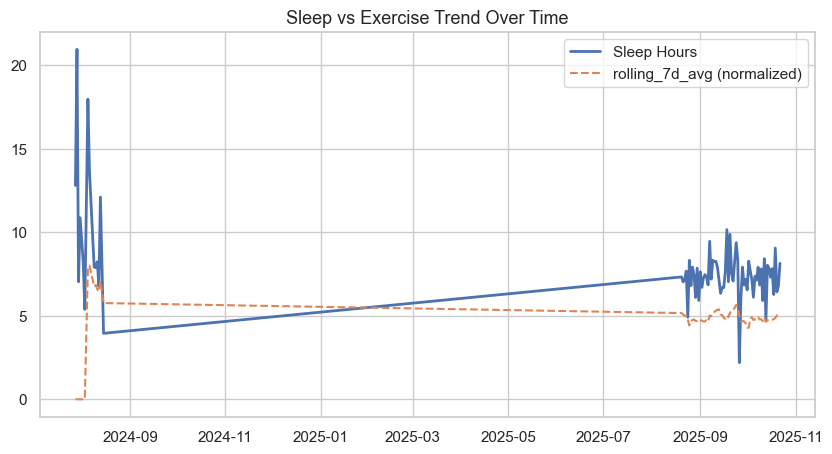

In [13]:
plt.figure(figsize=(10,5))
plt.plot(feature_df['date'], feature_df['total_sleep_hours'], label='Sleep Hours', linewidth=2)
if top_exercise in feature_df.columns:
    plt.plot(
        feature_df['date'], 
        feature_df[top_exercise] / feature_df[top_exercise].max() * 8,
        label=f"{top_exercise} (normalized)", linestyle='--'
    )

plt.title("Sleep vs Exercise Trend Over Time", fontsize=13)
plt.legend()
plt.show()


In [14]:
mean_sleep = feature_df['total_sleep_hours'].mean()
active_days = feature_df[feature_df[top_exercise] > feature_df[top_exercise].median()]
inactive_days = feature_df[feature_df[top_exercise] <= feature_df[top_exercise].median()]

sleep_diff = active_days['total_sleep_hours'].mean() - inactive_days['total_sleep_hours'].mean()

print("💡 Summary Insights:")
print(f"- Avg sleep duration: {mean_sleep:.2f}h")
print(f"- On more active days, you sleep {sleep_diff:+.2f}h longer on average.")
if sleep_diff > 0:
    print("→ Exercise seems to improve your sleep duration! 💤")
else:
    print("→ High activity might be reducing sleep — consider timing or intensity adjustments.")


💡 Summary Insights:
- Avg sleep duration: 7.85h
- On more active days, you sleep +0.46h longer on average.
→ Exercise seems to improve your sleep duration! 💤
